## Coursera Capstone project for week 3 part 2

In [26]:
# Importing necessory libraries
import pandas as pd
import lxml
import folium
import numpy as np
import json
import requests
from sklearn import preprocessing
from sklearn import cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors

In [20]:
website_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data = pd.read_html(website_url)

# The data frame of the postal codes is taken from first item of data
df = data[0]
# Renaming Column of neighborhood
df.rename(columns = {'Neighbourhood': 'Neighborhood'}, inplace = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [21]:
# Dataframe with Borough assigned entries
df = df[df.Borough != 'Not assigned']
# Reset the index
df.reset_index(inplace = True, drop = True)
df.head()


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [22]:
print("Shape of DatFrame: " + str(df.shape))

Shape of DatFrame: (103, 3)


##Working on geographical data

In [23]:
#Getting data from following link
urls = 'http://cocl.us/Geospatial_data'
geo_dataframe = pd.read_csv(urls)
geo_dataframe.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [24]:
#Save geospatial data in variable combined_dataframe
combined_dataframe = pd.merge(df, geo_dataframe, left_on = 'Postal Code', right_on = 'Postal Code')
#Now reset the indexes
combined_dataframe.reset_index(drop = True, inplace = True)
#Again print the shape of dataframe
print(combined_dataframe.shape)
#Check resulted data by calling function head()
combined_dataframe.head()

(103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


##Clustering the different postal codes

In [28]:
VERSION = '20180605' # Foursquare API version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret

In [45]:

url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
CLIENT_ID, CLIENT_SECRET, VERSION)
resulted_data = requests.get(url).json()

In [46]:
#Extracting related dictionares from overall data
food_samples = resulted_data['response']['categories'][3]
nightlife_samples = resulted_data['response']['categories'][4]
gym_samples = resulted_data['response']['categories'][5]['categories'][0]['categories'][7]

food_samples
nightlife_samples
gym_samples

{'categories': [{'categories': [],
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
    'suffix': '.png'},
   'id': '52f2ab2ebcbc57f1066b8b47',
   'name': 'Boxing Gym',
   'pluralName': 'Boxing Gyms',
   'shortName': 'Boxing Gym'},
  {'categories': [],
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
    'suffix': '.png'},
   'id': '503289d391d4c4b30a586d6a',
   'name': 'Climbing Gym',
   'pluralName': 'Climbing Gyms',
   'shortName': 'Climbing Gym'},
  {'categories': [],
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/bikeshop_',
    'suffix': '.png'},
   'id': '52f2ab2ebcbc57f1066b8b49',
   'name': 'Cycle Studio',
   'pluralName': 'Cycle Studios',
   'shortName': 'Cycle Studio'},
  {'categories': [],
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/pool_',
    'suffix': '.png'},
   'id': '4bf58dd8d48988d105941735',
   'name': 'Gym Pool',
   'pluralName': 'Gym Pools',
   'shortNam

In [48]:
def extract_id(dictlist):
    id_dictionary = {}
    if isinstance(dictlist, dict):
        id_dictionary[dictlist['name']] = dictlist['id']
        dictlist = dictlist['categories']
    for i in range(len(dictlist)):
        id_dictionary[dictlist[i]['name']] = dictlist[i]['id']
        if dictlist[i]['categories']:
            id_dictionary.update(extract_id(dictlist[i]['categories']))
    return id_dictionary

food_ids = extract_id(food_results)
nightlife_ids = extract_id(nightlife_results)
gym_ids = extract_id(gym_results)

gym_ids

{'Boxing Gym': '52f2ab2ebcbc57f1066b8b47',
 'Climbing Gym': '503289d391d4c4b30a586d6a',
 'Cycle Studio': '52f2ab2ebcbc57f1066b8b49',
 'Gym': '4bf58dd8d48988d176941735',
 'Gym / Fitness Center': '4bf58dd8d48988d175941735',
 'Gym Pool': '4bf58dd8d48988d105941735',
 'Gymnastics Gym': '52f2ab2ebcbc57f1066b8b48',
 'Martial Arts Dojo': '4bf58dd8d48988d101941735',
 'Outdoor Gym': '58daa1558bbb0b01f18ec203',
 'Pilates Studio': '5744ccdfe4b0c0459246b4b2',
 'Track': '4bf58dd8d48988d106941735',
 'Weight Loss Center': '590a0744340a5803fd8508c3',
 'Yoga Studio': '4bf58dd8d48988d102941735'}

In [49]:
radius = 2000
limit = 500
results = []

for i in range(len(combined_dataframe)):
    #Define coordinates
    neighborhood_latitude = combined_dataframe['Latitude'].iloc[i]
    neighborhood_longitude = combined_dataframe['Longitude'].iloc[i]
    
    #Retrieve JSON File
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius,
        limit)
    results.append(requests.get(url).json())

In [50]:

result_dict = {}
locs = ['Restaurants', 'Nightlife', 'Gyms',  'Total']
for i in range(len(results)):
    lr = [0, 0, 0, 0]
    lr[3] = len(results[i]['response']['venues'])
    for j in range(len(results[i]['response']['venues'])):
        if results[i]['response']['venues'][j]['categories']:            
            id = results[i]['response']['venues'][j]['categories'][0]['id']
            if id in list(food_ids.values()):
                lr[0] = lr[0] + 1
            elif id in list(nightlife_ids.values()):
                lr[1] = lr[1] + 1
            elif id in list(gym_ids.values()):
                lr[2] = lr[2] + 1
        
    result_dict[combined_dataframe['Postal Code'].iloc[i]] = dict(zip(locs, lr))
        
result_dict

{'M1B': {'Gyms': 4, 'Nightlife': 1, 'Restaurants': 21, 'Total': 122},
 'M1C': {'Gyms': 2, 'Nightlife': 2, 'Restaurants': 17, 'Total': 120},
 'M1E': {'Gyms': 0, 'Nightlife': 0, 'Restaurants': 12, 'Total': 67},
 'M1G': {'Gyms': 0, 'Nightlife': 2, 'Restaurants': 29, 'Total': 123},
 'M1H': {'Gyms': 3, 'Nightlife': 2, 'Restaurants': 26, 'Total': 124},
 'M1J': {'Gyms': 3, 'Nightlife': 0, 'Restaurants': 18, 'Total': 103},
 'M1K': {'Gyms': 1, 'Nightlife': 2, 'Restaurants': 20, 'Total': 120},
 'M1L': {'Gyms': 2, 'Nightlife': 0, 'Restaurants': 13, 'Total': 98},
 'M1M': {'Gyms': 3, 'Nightlife': 4, 'Restaurants': 23, 'Total': 117},
 'M1N': {'Gyms': 4, 'Nightlife': 6, 'Restaurants': 25, 'Total': 121},
 'M1P': {'Gyms': 2, 'Nightlife': 1, 'Restaurants': 15, 'Total': 124},
 'M1R': {'Gyms': 0, 'Nightlife': 4, 'Restaurants': 42, 'Total': 114},
 'M1S': {'Gyms': 1, 'Nightlife': 1, 'Restaurants': 17, 'Total': 123},
 'M1T': {'Gyms': 2, 'Nightlife': 0, 'Restaurants': 29, 'Total': 110},
 'M1V': {'Gyms': 1, 'N

In [57]:
feature_df = pd.DataFrame.from_dict(result_dict).transpose()
feature_df.drop(['Total'], axis = 1, inplace = True)
feature_df.reset_index(inplace = True)
feature_df.rename(columns = {"index" : "Postal Code"}, inplace = True)
feature_df.head()

,Postal Code,Restaurants,Nightlife,Gyms
0,M3A,7,2,0
1,M4A,11,1,1
2,M5A,18,2,1
3,M6A,7,1,2
4,M7A,9,1,0


In [58]:
feature_norm_df = preprocessing.StandardScaler().fit(feature_df[['Restaurants',  'Nightlife', 'Gyms']]).transform(feature_df[['Restaurants',  'Nightlife', 'Gyms']])

#Cluster object with 5 clusters run with 10 different initializations
k_means_model = cluster.KMeans(n_clusters = 5, init = 'k-means++', n_init = 10)

#Fit the normalized data
k_means_model.fit(feature_norm_df)

#Print labels
labels = k_means_model.labels_
print(labels)

[2 2 0 2 2 2 1 2 0 2 1 0 2 1 0 4 0 0 2 1 0 4 3 0 3 1 3 3 2 1 3 0 2 2 0 4 2
 4 0 2 0 1 3 0 2 2 0 0 3 0 2 0 0 0 0 3 0 2 1 3 3 2 1 3 3 2 1 1 2 2 0 3 2 2
 0 4 1 2 2 3 0 3 3 1 4 2 2 2 0 2 3 2 2 0 0 2 3 3 0 1 2 2 1]


In [59]:
combined_dataframe = pd.merge(combined_dataframe, feature_df, left_on = 'Postal Code', right_on = 'Postal Code')
combined_dataframe['Label'] = labels
combined_dataframe.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Restaurants_x,Nightlife_x,Gyms_x,Label,Restaurants_y,Nightlife_y,Gyms_y,Restaurants,Nightlife,Gyms
0,M3A,North York,Parkwoods,43.753259,-79.329656,7,2,0,2,7,2,0,7,2,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,11,1,1,2,11,1,1,11,1,1
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,18,2,1,0,18,2,1,18,2,1
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,7,1,2,2,7,1,2,7,1,2
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,9,1,0,2,9,1,0,9,1,0


Text(0.5, 0.92, 'Clustering results')

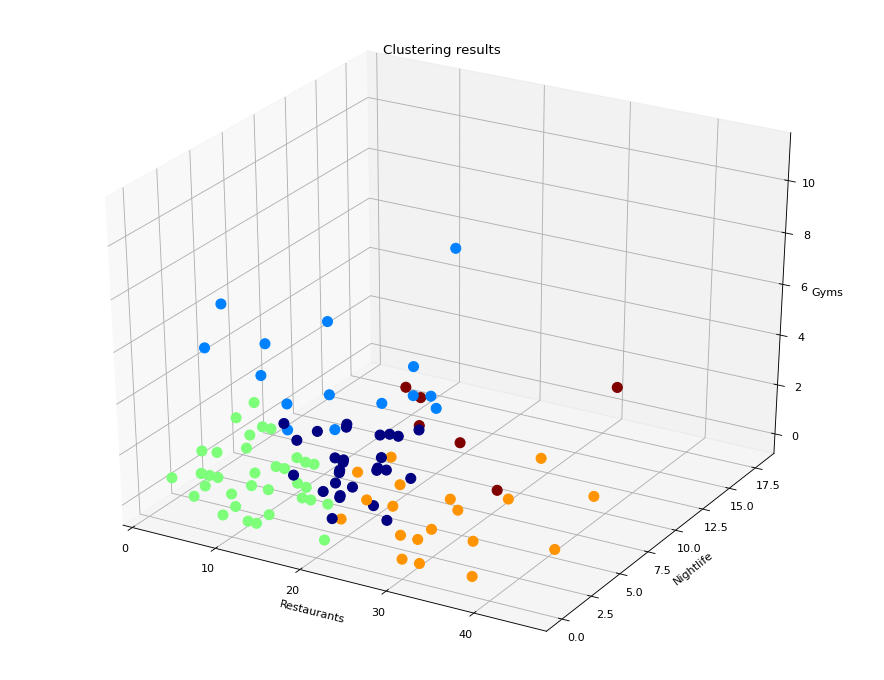

In [60]:

fig = plt.figure(figsize=(14, 11), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

ax.scatter(combined_dataframe['Restaurants'], combined_dataframe['Nightlife'], combined_dataframe['Gyms'], c = combined_dataframe['Label'],
           cmap = cm.jet, marker = 'o', s = 80, alpha = 1)

ax.set_xlabel('Restaurants')
ax.set_ylabel('Nightlife')
ax.set_zlabel('Gyms')
ax.set_title('Clustering results')

In [61]:

#Create Folium Map

cmap = cm.get_cmap('jet', combined_dataframe.Label.nunique())
colorlist = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colorlist.append(matplotlib.colors.rgb2hex(rgb))
    
    
    
m = folium.Map(location = [np.average(combined_dataframe['Latitude']), np.average(combined_dataframe['Longitude'])], 
               zoom_start = 11, control_scale = True)

for i, lat, long in zip(combined_dataframe.index, combined_dataframe['Latitude'], combined_dataframe['Longitude']):
    folium.Circle(
        location = [lat, long],
        radius = 200,
        color = colorlist[combined_dataframe.iloc[i].Label],
        fill = True,
        fill_color = colorlist[combined_dataframe.iloc[i].Label],
        fill_opacity = 1,
        popup = ("Label: "+ str(combined_dataframe.iloc[i].Label))
    ).add_to(m)
m